In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import contextlib
import gc
import random
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet121
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dense, Lambda, Dropout
from keras.optimizers import Adam
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
from labels import class_labels

In [3]:
train_dir     = 'train' 
val_dir       = 'val'
batch_size    = 64
img_size      = (224,224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            seed=123,
                                                            batch_size=batch_size,
                                                            image_size=img_size)

val_dataset   = tf.keras.utils.image_dataset_from_directory(val_dir,
                                                                 shuffle=True,
                                                                 seed=123,
                                                                 batch_size=batch_size,
                                                                 image_size=img_size)

Found 9469 files belonging to 10 classes.


2024-10-20 17:37:53.323552: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Found 3925 files belonging to 10 classes.


In [4]:
class_labels

['tench',
 'english springer',
 'cassette player',
 'chain saw',
 'church',
 'french horn',
 'garbage truck',
 'gas pump',
 'golf ball',
 'parachute']

In [5]:
#normalize data
normalization_layer = tf.keras.layers.Rescaling(scale=1./255)
train_dataset       = train_dataset.map(lambda x, y:(normalization_layer(x), tf.one_hot(y, depth=10)))
val_dataset         = val_dataset.map(lambda x, y:(normalization_layer(x),  tf.one_hot(y, depth=10)))

image_batch, _      = next(iter(train_dataset))
first_image         = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [6]:
for image, labels in train_dataset.take(1):
    print("Batch of images shape:", image.shape)
    print("Batch of labels shape:" ,labels.shape)

Batch of images shape: (64, 224, 224, 3)
Batch of labels shape: (64, 10)


In [7]:
val_batches  = tf.data.experimental.cardinality(val_dataset) #calculates the num of batches in the validation set
test_dataset = val_dataset.take(val_batches // 5) # take the first 20% of the val dataset to create the new test set
val_dataset  = val_dataset.skip(val_batches // 5) # skip the first 20% of the val dataset to keep remaining 80% as the new val set.

print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_dataset))
print("number of images in validation set :", len(val_dataset)*batch_size)
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))
print("number of images in test set :", len(test_dataset)*batch_size)

Number of validation batches: 50
number of images in validation set : 3200
Number of test batches: 12
number of images in test set : 768


In [8]:
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.backend import epsilon

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

In [10]:
import random

def set_random_seeds(seed_value):
    np.random.seed(seed_value)
    random.seed(seed_value)
    tf.random.set_seed(seed_value)

In [11]:
def create_model():
    base_model = tf.keras.applications.DenseNet121(include_top = False,
                                                   input_shape = (224,224,3),
                                                   weights     = 'imagenet',)
    base_model.trainable = False

    x       = base_model.output
    x       = GlobalAveragePooling2D()(x)
    x       = Dropout(0.2)(x)
    x       = Dense(512, activation ='relu')(x)
    x       = Dropout(0.4)(x)
    outputs = Dense(10, activation  ='softmax')(x)

    model   = tf.keras.Model(inputs = base_model.input, outputs=outputs)
    
    
    model.compile(optimizer=Adam(),
                 loss    = 'categorical_crossentropy',
                 metrics = ['accuracy',
                         Precision(name = 'precision'),
                         Recall(name    = 'recall'),
                         AUC(name       = 'auc'),
                         F1Score(name   = 'f1_score')])
    return model

In [8]:
num_trials  = 10
results     = []

# Create directory if it doesn't exist
save_dir    = "DenseNet_models"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for i in range(num_trials):
    print(f"Trial {i+1}")
    seed    = i  # Different seed for each trial
    set_random_seeds(seed)

    model   = create_model()
    
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=10, verbose=2)

    val_loss, val_acc, _, _, _, _ = model.evaluate(val_dataset)
    print(f"Validation Accuracy for trial {i+1}: {val_acc}")
    
    results.append({
        'trial'   : i+1,
        'seed'    : seed,
        'val_loss': val_loss,
        'val_acc' : val_acc,
        'history' : history.history
    })

    test_loss, test_acc, _, _, _, _ = model.evaluate(test_dataset)
    print(f"Test Accuracy for trial {i+1}: {test_acc}")
    
    model_name = f'DenseNet{i+1}.h5'
    model_path = os.path.join(save_dir, model_name)

    # Save the model if both validation and test accuracy are greater than 0.95
    if val_acc > 0.95 and test_acc > 0.95:
        model.save(model_path)
        print(f"Model saved as {model_path}")

Trial 4
Epoch 1/10


/opt/conda/lib/python3.11/site-packages/keras/src/engine/training.py:2699: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


148/148 - 56s - loss: 0.2575 - accuracy: 0.9222 - precision: 0.9575 - recall: 0.8997 - auc: 0.9942 - f1_score: 0.9277 - val_loss: 0.0608 - val_accuracy: 0.9772 - val_precision: 0.9843 - val_recall: 0.9747 - val_auc: 0.9995 - val_f1_score: 0.9795 - 56s/epoch - 382ms/step
Epoch 2/10
148/148 - 47s - loss: 0.0966 - accuracy: 0.9673 - precision: 0.9735 - recall: 0.9637 - auc: 0.9985 - f1_score: 0.9686 - val_loss: 0.0525 - val_accuracy: 0.9829 - val_precision: 0.9863 - val_recall: 0.9804 - val_auc: 0.9995 - val_f1_score: 0.9833 - 47s/epoch - 320ms/step
Epoch 3/10
148/148 - 48s - loss: 0.0754 - accuracy: 0.9747 - precision: 0.9793 - recall: 0.9729 - auc: 0.9989 - f1_score: 0.9761 - val_loss: 0.0559 - val_accuracy: 0.9810 - val_precision: 0.9847 - val_recall: 0.9794 - val_auc: 0.9997 - val_f1_score: 0.9821 - 48s/epoch - 322ms/step
Epoch 4/10
148/148 - 51s - loss: 0.0649 - accuracy: 0.9787 - precision: 0.9816 - recall: 0.9759 - auc: 0.9991 - f1_score: 0.9788 - val_loss: 0.0541 - val_accuracy: 0

/opt/conda/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as DenseNet_models/DenseNet4.h5
Trial 5
Epoch 1/10
148/148 - 54s - loss: 0.2516 - accuracy: 0.9232 - precision: 0.9606 - recall: 0.9045 - auc: 0.9949 - f1_score: 0.9317 - val_loss: 0.0806 - val_accuracy: 0.9759 - val_precision: 0.9798 - val_recall: 0.9702 - val_auc: 0.9990 - val_f1_score: 0.9750 - 54s/epoch - 365ms/step
Epoch 2/10
148/148 - 50s - loss: 0.1020 - accuracy: 0.9659 - precision: 0.9734 - recall: 0.9621 - auc: 0.9985 - f1_score: 0.9677 - val_loss: 0.0586 - val_accuracy: 0.9845 - val_precision: 0.9888 - val_recall: 0.9797 - val_auc: 0.9993 - val_f1_score: 0.9842 - 50s/epoch - 336ms/step
Epoch 3/10
148/148 - 50s - loss: 0.0724 - accuracy: 0.9768 - precision: 0.9804 - recall: 0.9741 - auc: 0.9992 - f1_score: 0.9773 - val_loss: 0.0517 - val_accuracy: 0.9842 - val_precision: 0.9866 - val_recall: 0.9813 - val_auc: 0.9992 - val_f1_score: 0.9840 - 50s/epoch - 338ms/step
Epoch 4/10
148/148 - 46s - loss: 0.0673 - accuracy: 0.9788 - precision: 0.9818 - recall: 0.9761 - auc:

In [11]:
for result in results:
    print(f"Trail {result['trial']}: Seed {result['seed']} - Validation Accuracy: {result['val_acc']}")

Trail 4: Seed 3 - Validation Accuracy: 0.9816281199455261
Trail 5: Seed 4 - Validation Accuracy: 0.9838454127311707
Trail 6: Seed 5 - Validation Accuracy: 0.9781438112258911
Trail 7: Seed 6 - Validation Accuracy: 0.9838454127311707
Trail 8: Seed 7 - Validation Accuracy: 0.9882799983024597
Trail 9: Seed 8 - Validation Accuracy: 0.9854292273521423
Trail 10: Seed 9 - Validation Accuracy: 0.9813113808631897


In [25]:
models      = []

save_dir = 'models/diff_seeds'

for model_file in os.listdir(save_dir):
    if model_file.endswith(".h5"):
        model_path = os.path.join(save_dir, model_file)
        model = tf.keras.models.load_model(model_path)
        models.append(model)

for i, model in enumerate(models):
    model._name = f"dense{i+1}"
    model_names.append(model.name)

In [26]:
models[0].summary()

Model: "dense1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 230, 230, 3)          0         ['input_2[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_2[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']     

In [10]:
import helper_functions

sample_lists = [helper_functions.get_sample(class_index=i, dataset=test_dataset) for i in range(10)]
predictions  = [helper_functions.get_predictions(models, sample_list) for sample_list in sample_lists]
new_lists    = [helper_functions.filter_correct_predictions(prediction) for prediction in predictions]

Wrong Prediction at index 25 by dense3: Predicted chain saw, True tench
Wrong Prediction at index 45 by dense1: Predicted parachute, True english springer
Wrong Prediction at index 57 by dense7: Predicted golf ball, True english springer
Wrong Prediction at index 3 by dense7: Predicted chain saw, True cassette player
Wrong Prediction at index 28 by dense7: Predicted golf ball, True cassette player
Wrong Prediction at index 39 by dense2: Predicted gas pump, True cassette player
Wrong Prediction at index 55 by dense7: Predicted gas pump, True cassette player
Wrong Prediction at index 59 by dense7: Predicted gas pump, True cassette player
Wrong Prediction at index 65 by dense1: Predicted golf ball, True cassette player
Wrong Prediction at index 11 by dense1: Predicted parachute, True chain saw
Wrong Prediction at index 19 by dense5: Predicted cassette player, True chain saw
Wrong Prediction at index 22 by dense8: Predicted cassette player, True chain saw
Wrong Prediction at index 29 by de

In [66]:
# sample_lists

In [11]:
%%time
import LIME
save_directory = 'LIME expls/diff_seeds' #multi densenet/lime_expls/new

with open(os.devnull, 'w') as f:
    with contextlib.redirect_stdout(f):
        LIME.generate_and_save_explanations(new_lists, models, 1000, save_directory)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 14d 3h 14min 34s, sys: 20h 53min 39s, total: 15d 8min 13s
Wall time: 1d 9h 42min 12s


In [ ]:
# Generate SHAP explanations

In [13]:
%%time
import SHAP
importlib.reload(SHAP)

save_directory = 'SHAP expls/diff_seeds' #'multi densenet/shap_expls'

with open(os.devnull, 'w') as f:
    with contextlib.redirect_stdout(f):
        SHAP.generate_and_save_explanations(new_lists, models, save_directory)

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.59s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.88s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.71s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.81s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.22s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.38s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.44s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.48s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.35s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.87s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.26s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.55s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.63s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.30s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.89s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.09s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.25s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.12s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.23s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.36s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.15s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.37s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.37s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.90s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.69s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:24, 24.94s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:24, 24.73s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.38s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.01s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.01s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.70s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.71s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.89s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.12s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.79s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.29s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.14s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.45s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.90s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.16s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.96s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.56s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.86s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.82s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.81s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.64s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.50s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.30s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.82s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.69s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.96s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.87s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.64s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.34s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.76s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.72s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.53s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.55s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.68s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.93s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.37s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.89s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.29s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.33s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.55s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.67s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.85s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.86s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.46s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.54s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.30s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.34s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.51s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.82s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.06s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.18s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.57s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.21s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.78s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.98s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.02s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.89s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.96s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.26s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.09s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.49s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.72s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.16s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.13s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.09s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.76s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.50s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.97s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.93s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.06s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.50s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.81s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.90s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.47s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.85s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.61s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.23s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.33s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.72s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.79s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.40s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.23s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.96s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.91s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.47s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.69s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.16s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.07s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.86s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.94s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.79s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.07s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.63s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.66s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.04s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.26s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.15s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.86s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.52s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.79s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.50s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.18s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.58s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.28s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.26s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.86s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.80s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.29s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.06s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.47s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.65s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.51s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.79s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.66s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.75s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.49s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.02s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.08s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.49s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.05s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.90s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.98s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.91s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.46s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.42s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.70s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.87s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.55s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.95s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:24, 24.56s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.02s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.35s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.03s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.21s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.98s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.90s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.58s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.17s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.66s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.68s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.38s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.21s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.05s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.36s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.25s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.81s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.91s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.93s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.79s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.41s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.64s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.18s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.88s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.52s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.08s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.25s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.73s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.30s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.28s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.04s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.89s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.24s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.96s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.44s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.16s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.44s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.56s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.84s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.19s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.95s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.04s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.12s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.97s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.97s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.51s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.37s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.02s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.31s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.16s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.57s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.02s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.33s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.15s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.63s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.52s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.84s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.17s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.95s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.32s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.96s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.78s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.98s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:24, 24.21s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.08s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.26s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.54s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.61s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.41s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.94s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.86s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.84s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.30s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.62s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.81s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:24, 24.57s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.34s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.93s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.12s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.92s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.04s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.63s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.33s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.95s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:24, 24.84s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.73s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.87s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.23s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.71s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.25s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.30s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.81s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.42s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.31s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.63s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 28.00s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.04s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.23s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.79s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.61s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.40s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.62s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.22s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.77s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.91s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.87s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.31s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.57s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.82s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.01s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.07s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.56s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.94s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.49s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.22s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.46s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.00s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.38s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.47s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.76s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.66s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.93s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.14s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.93s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.27s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.27s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.59s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:24, 24.61s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:24, 24.84s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.08s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.59s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.58s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.66s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.79s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.17s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.88s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.79s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.07s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.49s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.57s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.94s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.99s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.37s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.41s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.89s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.02s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.43s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.44s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.72s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.14s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.87s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.74s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.44s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.99s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.95s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 28.00s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.33s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.39s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.89s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.22s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.73s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.82s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.10s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.26s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.29s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.92s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.51s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.53s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.61s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.78s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.17s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.28s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.07s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.77s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.10s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.19s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.65s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.11s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.45s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.56s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.49s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.25s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.45s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.22s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.16s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.43s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.40s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.36s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.35s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.24s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.72s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.83s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.74s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.98s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.36s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.60s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.06s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.25s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.67s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.46s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.73s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.71s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.10s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.46s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.90s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.45s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.12s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.48s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.76s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.22s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.02s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.32s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.05s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.07s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.70s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.96s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.76s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.49s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.67s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.17s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.87s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.67s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.58s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.69s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.66s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.60s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.76s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.90s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.69s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.52s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:24, 24.78s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.68s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.86s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.21s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.83s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.94s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.29s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.33s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.42s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.27s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.78s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.61s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.46s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.40s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.07s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.70s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.45s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.58s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.93s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.19s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.63s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.06s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.40s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.75s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.25s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:23, 23.57s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:23, 23.64s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.31s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.44s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.43s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.71s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.26s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.49s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.83s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.62s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.71s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.78s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.20s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.64s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.58s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.86s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.94s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.99s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.92s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.80s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.57s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:24, 24.49s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.32s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.60s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.43s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.63s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.34s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.57s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.38s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.80s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.29s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.42s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.79s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.56s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:24, 24.84s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.86s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.48s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.90s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.46s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.27s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.92s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.19s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.05s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 29.00s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.00s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.63s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.94s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.85s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.75s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.02s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.23s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.39s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.91s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.81s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.78s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.49s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.80s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.60s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.46s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.08s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.79s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 29.00s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.12s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.63s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.60s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:24, 24.04s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.39s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.42s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.14s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.47s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.74s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.32s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.65s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.32s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.98s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.18s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.29s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.62s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.74s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.96s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.83s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.48s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.67s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.25s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.26s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.65s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.15s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.81s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.61s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.17s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.21s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.12s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.81s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.13s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.20s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.33s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.55s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.31s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.04s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.78s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.81s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.88s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.04s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.96s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.93s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.83s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.10s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.23s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.95s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.40s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.43s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.17s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.34s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.48s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.58s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.78s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.04s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.82s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.29s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.74s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.68s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.47s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.59s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.54s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.35s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.23s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.40s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.22s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.24s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.57s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.77s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.55s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.81s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.89s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.40s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.04s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.14s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.98s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.58s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.12s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.44s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.47s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.46s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.63s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.16s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.16s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.53s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.40s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.30s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.66s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.25s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.57s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.26s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.82s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.06s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.60s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.84s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.49s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.43s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.19s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.19s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.76s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.93s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.94s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.63s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.39s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.68s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.37s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.19s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.76s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.57s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.92s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.67s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.38s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.17s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.27s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.71s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.48s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.56s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.52s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.82s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.13s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.36s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.03s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.64s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.90s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.68s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.20s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.54s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.85s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.08s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.92s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:24, 24.39s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:24, 24.73s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.45s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.88s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.14s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.56s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.49s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.31s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.91s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.00s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.85s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.73s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.51s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.70s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.87s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.31s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.08s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.05s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.48s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.12s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.46s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.06s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.55s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.23s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.21s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.69s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.84s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:24, 24.41s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.76s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.05s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.40s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.94s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.49s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.67s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.45s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.22s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.57s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.21s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.05s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.70s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.08s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.01s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.31s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.15s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.62s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.02s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.36s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.41s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.67s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.19s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.06s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.30s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.33s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.56s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.47s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.84s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.85s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.89s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.37s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.64s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.32s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.14s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.87s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.85s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.89s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.54s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.11s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.88s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.80s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.42s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.65s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.32s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.67s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.07s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.91s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.62s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.28s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.06s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.02s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.20s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.87s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.83s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.09s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.63s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.35s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.74s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.86s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.71s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.63s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.15s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.33s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.67s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.68s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.66s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.04s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.58s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.02s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.66s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.55s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.68s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.40s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.40s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.84s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.13s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.97s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.31s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.80s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.91s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.58s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.41s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.72s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.97s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.18s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.52s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.67s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.69s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.20s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.04s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.46s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.66s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.69s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.65s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.23s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.74s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.32s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.17s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:24, 24.67s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.87s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.44s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.38s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.32s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.96s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.34s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.05s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.80s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.41s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.84s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.15s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.52s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.11s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.48s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.19s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.54s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.28s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.48s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.26s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.77s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.87s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.90s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.47s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.55s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.37s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.07s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.98s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.02s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.59s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.97s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.72s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.68s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.49s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.23s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.27s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.04s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.93s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.95s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.61s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.32s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.88s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.18s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.48s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.97s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.48s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.15s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.89s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.60s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.84s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.21s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.47s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.59s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.60s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.30s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.82s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.21s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.75s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.83s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.81s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.64s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.14s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.61s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.70s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.31s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.55s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.43s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.28s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.47s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.61s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.85s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.04s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.51s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.79s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.10s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.63s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.28s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.45s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.90s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:33, 33.19s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.07s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.06s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.39s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.63s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.66s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.58s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.10s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.53s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.56s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.58s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.32s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.40s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.03s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.22s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.46s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.86s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.31s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.46s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.13s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.29s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.13s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.19s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.82s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.84s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.08s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.54s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.91s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.29s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.97s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.70s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.60s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.32s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.53s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.14s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.60s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.19s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.51s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.64s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.34s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.77s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.82s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.01s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.26s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.97s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.81s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.68s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.89s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.40s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.31s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.50s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.25s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.18s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.61s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.75s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.80s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.10s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.32s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.98s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.97s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.53s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.94s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.03s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.99s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.47s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.31s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.90s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.54s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.22s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.38s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.28s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.05s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.14s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.81s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.38s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.31s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.61s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.66s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.45s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.60s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.17s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.27s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.18s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.61s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.02s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.58s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.94s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.58s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.71s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.04s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.29s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.60s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.83s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.50s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.91s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.94s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.55s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.13s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.37s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.56s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.53s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.81s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.00s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.04s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.19s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.56s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.48s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.67s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.61s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.61s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.67s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.37s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 28.00s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 29.00s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.22s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.30s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.59s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.99s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.16s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.51s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.91s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.26s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.12s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.31s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.71s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.78s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.22s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.44s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.37s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.16s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.60s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.44s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.94s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.69s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.24s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.87s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.68s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.78s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.76s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.78s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.08s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.67s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.67s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.58s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.18s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.40s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.53s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.33s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.90s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.97s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.45s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.26s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.82s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.96s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.06s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.87s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.58s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.38s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.54s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.67s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.79s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.65s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.88s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.26s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.06s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.36s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.73s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.06s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.53s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.11s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.09s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.95s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.28s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.23s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.18s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.86s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.22s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.35s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.28s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.32s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.24s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.10s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.95s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.78s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.59s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.43s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.45s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.26s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.86s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.97s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.72s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.57s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.88s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.19s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.79s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.78s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.22s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.95s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.14s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.63s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.81s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.51s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.73s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.70s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.30s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.43s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.34s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.66s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.16s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.36s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.02s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.60s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.47s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.40s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.10s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.55s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.04s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.20s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.14s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.64s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.45s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.85s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.07s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.19s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.80s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.34s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.44s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.83s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.40s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.68s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.86s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.17s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.51s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.22s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.39s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.22s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.43s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.03s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.82s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 30.00s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.16s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.50s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.14s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.49s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.26s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.05s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.19s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.77s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.78s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.61s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.75s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.80s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.75s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.35s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.18s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.43s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.09s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.42s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.13s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.92s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.64s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.17s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.57s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.96s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.89s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.55s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.03s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.21s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.34s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.67s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.44s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.68s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.13s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.93s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.97s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.60s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.35s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.25s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.95s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.93s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.04s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.41s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.04s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.49s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.07s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.25s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.81s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.36s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.20s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.59s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.73s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.73s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.41s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.43s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:24, 24.95s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.12s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.62s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.35s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.95s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.37s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.51s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.42s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.72s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.62s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.73s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.43s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.72s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.71s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.43s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.89s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.81s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.67s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.78s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.13s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.35s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.07s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.57s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.92s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.51s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.78s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.56s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.68s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.76s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.14s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.90s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.19s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.43s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.66s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.95s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.70s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.65s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.96s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.63s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.42s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.99s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.73s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.43s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.25s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.22s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.41s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.03s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 29.00s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.88s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.17s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.24s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.29s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.71s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.76s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.89s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.68s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.04s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.82s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.70s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.39s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.38s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.44s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.65s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.48s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.90s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.39s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.07s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.01s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 30.00s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.85s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.41s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.39s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.08s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.74s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.82s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.28s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.34s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.97s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.41s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.87s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.33s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.56s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.57s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.59s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.88s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.06s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.40s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.10s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.67s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.44s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.21s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.63s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.83s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.53s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.76s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.03s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.90s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.27s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.27s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.01s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.56s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.67s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.21s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.71s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.98s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.91s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.05s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.36s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.02s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.19s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.13s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.56s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.79s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.79s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.83s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.35s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.95s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.33s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.60s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.19s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.82s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.27s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.57s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.81s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.67s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.55s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.42s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.78s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.86s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.99s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.79s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.30s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.14s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.21s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.46s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.61s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.00s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.01s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.44s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.43s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.11s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.43s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.09s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.52s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.80s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.30s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.71s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.48s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.93s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.24s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.66s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.03s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.55s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.19s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.31s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.54s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.82s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.93s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.66s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.56s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.50s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.44s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.26s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.12s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.42s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.36s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.05s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.74s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.13s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.41s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.06s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.30s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.37s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.36s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.90s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.12s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.38s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.45s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.49s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.06s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.68s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.88s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.58s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.51s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.97s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.69s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.60s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.10s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.72s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.31s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.58s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.51s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.73s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.31s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.88s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.72s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.06s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.60s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.18s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.67s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.13s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.10s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.55s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.54s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.12s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.75s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.41s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.24s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.15s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.13s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.52s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.76s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.66s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.30s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.43s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.51s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.24s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.99s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.55s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.86s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.65s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.33s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.06s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.02s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.32s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.30s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.45s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.54s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.69s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.32s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.19s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.56s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.31s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.52s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.90s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.50s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.58s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.68s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.34s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.44s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.09s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.19s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.06s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.19s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.12s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.23s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.06s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.61s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.09s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.63s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.56s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.13s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.79s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.23s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.57s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.07s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.24s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.27s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.71s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.09s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.93s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.78s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.09s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.59s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.47s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 30.00s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.08s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.10s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.25s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.86s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.39s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.50s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.64s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.67s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.29s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.88s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.22s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.55s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.25s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.56s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.57s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.53s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.63s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.33s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.24s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.75s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.39s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.24s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.40s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.58s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.32s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.60s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.88s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.19s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.18s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.02s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.02s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.52s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.14s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.70s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.17s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.95s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.15s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.50s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.25s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.26s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.69s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.55s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.17s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.09s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.88s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.72s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.07s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.36s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.06s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.05s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.53s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.81s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.41s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.06s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.31s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.38s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.37s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.79s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.61s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.82s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.29s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.06s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.90s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.30s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.73s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.75s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.69s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.42s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.06s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.12s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.96s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.59s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.57s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.27s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.40s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.21s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.36s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.54s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.63s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.56s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.82s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.33s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.64s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.22s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.10s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.04s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.38s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.07s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.92s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.09s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.29s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.30s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.29s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.87s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.44s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.11s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.88s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.64s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.79s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.13s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.76s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.05s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.69s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.19s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.70s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.92s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.71s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.69s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.46s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.08s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.02s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.02s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.85s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.38s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.66s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.31s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.46s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.08s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.33s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.23s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.31s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.28s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.03s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.86s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.99s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.98s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.38s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.25s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.17s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.24s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.27s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.18s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.36s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.57s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.77s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.57s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.73s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.42s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.04s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.30s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.87s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.44s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.70s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.42s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.30s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.68s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.31s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.39s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.83s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.63s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.27s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.56s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.34s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.36s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.95s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.81s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.83s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.96s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.29s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.20s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.05s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.93s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.69s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.98s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.18s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.06s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.58s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.01s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.66s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.02s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.14s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.64s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.64s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.56s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.02s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.08s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.43s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.65s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.22s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.89s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.11s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.84s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.41s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.10s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.72s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.50s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.71s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.05s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.84s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.22s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.90s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.23s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.74s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.71s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.03s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.03s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.82s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.15s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.46s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.13s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.46s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.22s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.05s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.87s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.45s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.49s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.23s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.29s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.67s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.72s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.03s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.06s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.36s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.69s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.06s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.08s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.48s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.48s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.01s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.58s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.69s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.75s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.67s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.85s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.38s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.61s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.78s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.37s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.22s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.33s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.96s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.64s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.25s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.31s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.13s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.49s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.44s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.88s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.50s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.94s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.20s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.58s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.51s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.20s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.16s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.69s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.23s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.55s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.17s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.64s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.31s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.18s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.15s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.73s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.24s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.58s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.45s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.97s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.83s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.32s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.87s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.54s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.66s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.39s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 31.00s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.74s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.36s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.18s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.97s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.90s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.93s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.36s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.14s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.47s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.80s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.85s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.32s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.27s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.91s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.94s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.06s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.29s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.73s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.34s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.68s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.70s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.84s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.04s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.78s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.41s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.75s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.27s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.09s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.08s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.68s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.84s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.44s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.93s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.10s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.22s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.41s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.90s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.68s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.59s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.69s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.94s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.82s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.12s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.87s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:33, 33.67s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:34, 34.81s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:34, 34.31s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.87s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.92s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.09s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.96s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.49s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.87s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.06s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.36s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.87s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.78s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.25s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.86s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.98s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.36s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.67s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.59s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.01s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.78s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.61s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.61s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.59s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.45s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.54s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.69s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.59s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.04s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.57s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.08s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.54s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.23s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.85s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.18s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.54s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.74s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.46s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.14s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.01s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.83s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.97s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.10s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.91s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.46s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.99s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.57s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.44s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.46s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.66s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.14s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.07s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.63s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.49s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.40s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.29s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.91s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.67s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.43s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.29s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.58s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.10s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.94s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.61s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.43s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.89s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.84s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.38s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.37s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.59s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.92s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.07s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.95s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.64s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.32s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.95s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.25s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.01s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.09s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.70s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.51s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.79s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.42s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.28s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.56s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.04s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.50s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.60s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.94s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.41s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.45s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.55s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.32s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.59s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.43s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.73s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.86s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.78s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.07s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.69s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.13s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.54s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.88s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.99s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.61s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.63s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.81s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.54s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.29s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.82s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.80s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.98s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.31s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.39s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.53s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.24s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.30s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.40s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.33s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.71s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.93s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.51s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.04s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.70s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.60s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.45s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.50s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.78s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.34s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.98s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.57s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.03s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.69s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.39s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.07s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.00s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.30s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.35s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.62s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.53s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.68s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.34s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.56s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.19s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.30s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.21s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.61s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.12s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.44s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.84s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.60s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.72s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.48s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.33s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.58s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.38s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.57s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.45s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.99s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.77s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.67s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.55s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.05s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.82s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.36s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.81s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.71s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.91s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.15s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.63s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.88s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.69s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.03s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.12s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.77s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.74s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.38s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.34s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.18s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.81s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.03s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.97s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.97s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.41s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.01s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.77s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.26s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.25s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.47s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.52s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.98s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.22s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.04s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.79s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.47s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.41s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.54s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.56s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.21s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.38s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.12s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.96s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.54s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.37s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.05s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.33s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.76s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.24s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.48s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.50s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.99s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.07s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.47s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.30s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.84s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.44s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.77s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.79s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.08s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.93s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.16s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.07s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.63s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.99s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.91s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.91s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.06s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.46s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.90s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.20s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.01s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.80s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.25s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.45s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.46s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.28s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.85s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.42s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.48s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.94s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.25s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.62s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.74s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.06s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.88s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.79s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.85s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.34s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.09s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.08s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.91s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.82s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.94s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.42s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.31s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.03s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.47s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.65s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.48s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.83s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.08s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.96s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.92s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.77s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.37s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.60s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.35s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.91s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.32s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.95s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.01s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.97s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.59s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.40s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.14s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.44s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.39s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.39s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.70s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.82s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.98s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.96s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.52s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.13s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.12s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.13s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.26s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.96s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.08s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.26s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.62s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.47s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.43s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.62s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.76s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.71s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.14s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.67s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.22s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.72s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.64s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.13s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.98s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.85s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.35s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.05s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.02s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.46s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.14s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.36s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.19s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.82s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.58s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.55s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.76s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.07s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.68s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.05s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.68s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.12s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.62s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.84s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.40s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.60s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.19s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.43s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.50s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.28s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.39s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.88s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.76s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.45s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.36s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.24s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.62s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.71s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.50s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.87s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.04s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.81s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.46s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.02s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.82s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.89s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.58s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.50s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.75s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.33s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.56s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.32s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.95s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.78s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.59s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.50s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.75s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.35s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.81s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.41s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.83s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.20s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.63s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.25s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.67s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.06s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.98s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.78s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.83s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.28s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.53s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.75s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.23s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.72s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.14s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.76s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.26s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.75s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.60s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.55s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.77s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.79s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.79s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.21s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.26s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.67s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.82s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.01s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.88s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.81s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.24s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.92s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.94s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.68s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.88s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.58s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.37s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.04s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.43s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.55s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.87s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.12s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.06s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.76s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.15s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.10s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.88s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.39s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.70s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.96s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.42s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.96s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.99s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.11s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.97s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.34s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.45s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.62s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.69s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.34s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.85s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.20s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.55s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.86s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.47s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.01s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.72s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.86s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.49s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.54s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.93s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.67s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.55s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.54s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.42s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.15s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.40s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.15s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.27s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.94s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.93s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.86s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.90s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.55s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.76s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.75s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.39s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.27s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.35s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.80s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.99s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.84s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.26s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.42s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.17s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.52s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.49s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.47s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.28s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.89s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.29s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.10s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.27s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.52s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.29s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.43s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.93s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.57s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.64s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.64s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.78s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.90s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.02s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.79s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.93s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.40s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.27s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.52s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.19s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.62s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.43s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.19s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.60s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.49s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.53s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.32s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.24s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.71s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.54s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.26s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.52s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.13s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.75s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.70s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.94s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.22s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.84s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.04s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.53s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.68s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.36s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.98s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.01s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.54s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.31s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.83s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.60s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.27s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.05s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.66s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.81s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.98s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.88s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.27s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.22s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.10s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.68s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.69s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.73s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.17s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.74s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.63s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.04s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.83s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.65s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.73s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.16s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.81s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.97s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.82s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.12s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.97s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.43s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.13s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.95s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.79s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.83s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.98s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.83s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.31s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.31s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.08s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.64s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.13s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.62s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.23s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.64s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.09s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.57s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.63s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.28s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.41s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.78s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.64s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.22s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.97s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.16s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.94s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.83s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.44s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.18s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.61s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.85s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.38s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.19s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.23s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.30s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.22s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.50s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.22s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.93s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.74s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.87s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.62s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.82s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.18s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.95s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.63s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.50s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.32s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.89s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.81s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.27s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.28s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.79s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.60s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.52s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.80s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.92s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.87s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.35s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.58s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.03s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.42s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.45s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.66s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.02s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.55s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.86s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.14s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.64s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.82s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.92s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.77s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.77s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.22s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.55s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.83s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.93s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.11s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.99s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.72s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.88s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.47s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.98s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.89s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.71s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.76s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.02s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.19s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.22s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.08s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.45s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.73s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.07s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.68s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.02s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.25s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.62s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.31s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.70s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.94s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 30.00s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.93s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.07s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.67s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.20s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.88s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.27s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.43s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.12s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.97s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.44s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.96s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.67s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.40s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.86s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.20s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.19s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.51s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.56s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.96s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.89s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.98s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.45s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.54s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.99s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.84s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.54s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.09s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.34s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.55s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.60s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.70s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.78s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.85s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.97s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.95s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.13s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.78s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.50s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.44s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.35s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.38s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.64s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.96s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.97s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.77s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.25s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.96s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.93s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.96s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.48s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.32s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.92s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.99s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.95s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.56s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.47s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.27s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.95s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.46s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.48s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.93s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.75s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.83s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.40s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.01s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.55s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.14s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.19s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.03s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.53s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.38s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.26s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.84s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.59s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.41s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.68s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.60s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.28s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.21s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.86s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.90s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.35s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.20s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.57s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.97s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.05s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.49s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.09s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.09s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.89s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.03s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.84s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.46s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.73s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.48s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.45s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.74s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.51s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.72s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 32.00s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.90s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.35s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.17s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.78s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.64s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.54s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.94s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.72s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.95s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.24s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.15s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.79s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.95s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.81s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.10s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.95s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.76s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.38s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.30s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.86s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.80s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.45s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.22s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.99s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.62s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.44s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.13s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.54s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.62s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.12s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.22s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.95s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.47s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.16s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.51s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.12s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.14s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.64s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.07s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.26s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.57s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.72s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.73s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.02s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.72s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.52s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.53s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.28s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.47s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.55s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.03s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.46s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.98s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.75s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.16s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.89s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.74s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.24s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.44s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.09s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.62s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.31s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.06s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.57s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.03s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.97s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.45s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.17s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.61s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.56s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.09s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.90s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.87s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.72s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.33s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.94s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.61s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.18s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.11s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.36s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.66s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.69s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 32.00s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.14s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.77s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.63s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.70s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.85s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.55s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.86s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.12s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.40s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.61s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.12s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.14s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.52s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.58s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.84s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.45s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.63s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.38s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.10s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.82s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.42s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.55s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.04s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.72s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.66s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.82s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.94s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.11s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.69s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 31.00s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.75s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.05s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.31s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.18s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.50s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 30.00s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.86s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.60s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.83s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.43s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.66s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.44s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.28s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.11s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.23s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.27s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.54s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.80s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.76s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.25s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.62s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.56s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.33s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.38s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.37s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.75s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.46s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.02s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.71s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.91s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.11s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.64s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.89s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.31s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.98s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.03s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.89s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.75s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.86s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.25s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.48s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.99s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.56s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.85s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.63s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.83s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.40s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.97s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.97s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.97s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.11s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.66s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.88s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.50s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.86s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.47s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.89s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.30s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.57s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.63s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.09s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.91s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.50s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.55s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.06s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.79s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.51s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.56s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.10s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.63s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.20s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.87s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.79s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.62s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.79s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.03s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.78s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.02s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.63s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.43s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.17s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.24s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.77s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.92s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.90s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.20s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.32s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.45s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.75s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.26s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.27s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.29s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.83s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.61s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.60s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.55s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.06s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.58s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.24s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.85s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.34s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.09s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.89s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.30s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.90s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.53s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.67s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.14s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.15s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.26s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.04s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.00s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.44s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.27s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.92s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.29s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.37s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.05s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.17s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.60s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.73s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.80s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.49s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.93s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.79s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.90s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.34s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.47s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.67s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.15s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.82s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.57s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.76s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.19s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.43s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.69s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.81s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.61s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.77s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.23s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.77s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.04s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.19s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.07s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.60s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.60s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.38s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.58s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.94s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.00s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.50s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.78s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.03s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.68s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.71s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.02s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.54s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.44s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.26s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.64s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.21s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.28s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.70s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.40s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.56s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.08s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.79s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.52s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.45s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.75s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.96s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.15s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.22s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.63s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.32s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.93s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.56s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.84s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.49s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.44s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.38s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.14s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.11s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.91s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.78s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.13s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.98s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.56s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.59s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.15s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.94s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.66s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.24s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.63s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.33s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.47s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.50s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.76s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.58s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.10s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.41s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.64s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.53s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.24s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.76s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.40s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.12s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.89s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.84s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.47s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.73s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.52s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.82s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.44s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.83s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.47s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.37s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.92s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.85s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.44s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.83s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.94s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.74s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.20s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.58s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.31s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.72s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.94s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.16s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.52s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.54s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.16s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.59s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.57s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.37s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.67s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.56s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.88s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.51s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.43s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.14s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.85s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.62s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.46s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.96s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.16s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.54s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.23s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.04s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.25s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.88s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.38s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.38s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.21s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.38s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.10s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.85s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.85s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.35s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.14s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.49s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.44s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.83s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.36s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.22s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.64s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.78s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.68s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.13s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.57s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.49s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.17s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.04s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.61s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.72s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.76s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.73s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.73s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.92s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.66s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.43s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.54s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.86s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.78s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.12s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.91s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.67s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.68s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.91s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.68s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.75s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.42s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.00s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.31s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.76s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.71s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.29s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.17s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.10s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.31s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.82s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.56s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.95s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.15s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.91s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.79s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.69s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.14s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.57s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.19s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.95s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.20s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.77s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.54s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.28s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.59s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.57s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.49s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.66s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.62s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.62s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.79s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.39s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.72s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.15s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.89s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.43s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.97s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.50s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.99s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.63s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.31s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.01s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.01s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.30s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.76s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.02s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.09s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.16s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.16s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.75s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.98s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.94s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.58s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.62s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.90s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.74s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.87s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.66s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 32.00s/it]                                                                    


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.04s/it]                                                                    


CPU times: user 5d 3h 58min 27s, sys: 2h 38min 18s, total: 5d 6h 36min 46s
Wall time: 23h 49min 35s


In [ ]:
# LIME : 1d 9h 42min 12s
# SHAP : 23h 49min 35s

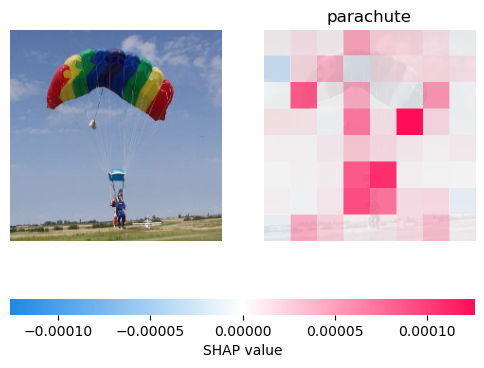

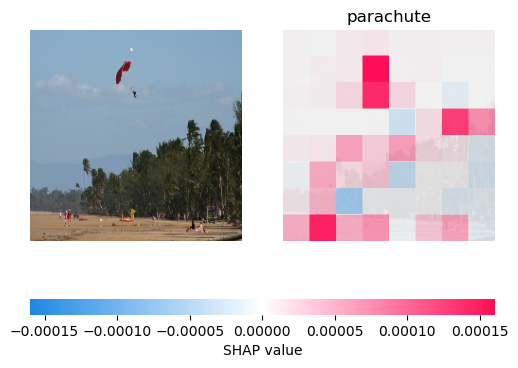

In [14]:
import shap
import pickle

with open('SHAP expls/diff_seeds/explain_parachute_model9_shap.pkl', 'rb') as file:
    parachute = pickle.load(file)
for shap_explanation in parachute[:2]:
    shap.image_plot(shap_explanation[0])

In [15]:
print(len(parachute))

76


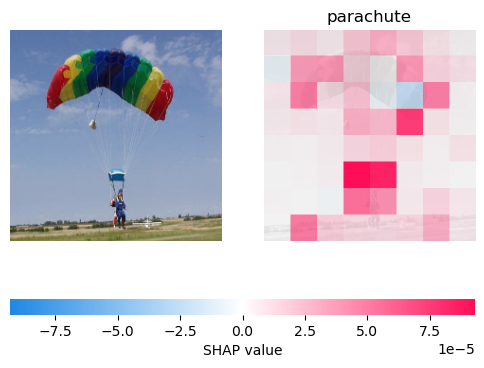

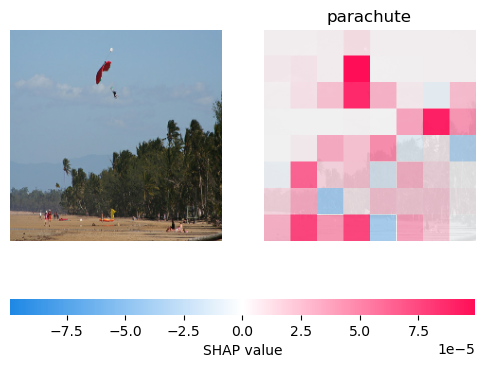

In [16]:
with open('SHAP expls/diff_seeds/explain_parachute_model1_shap.pkl', 'rb') as file:
    parachute = pickle.load(file)
for shap_explanation in parachute[:2]:
    shap.image_plot(shap_explanation[0])